## インポートライブラリ

In [ ]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import statistics

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Google driveマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# パス設定

## 画像・モデルのパス指定


In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/Drone_TA/Custum_Dataset/Car/JPEGImages/'
MASK_PATH = '/content/drive/MyDrive/Drone_TA/Custum_Dataset/Car/SegmentationClass/'

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Drone_TA/Custum_Model/drone_Trained.pth'

## 出力画像の保存先指定

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/Drone_TA/Custum_Model_Result/'

# データ設定

## データセットの構築

In [ ]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()

In [ ]:
X_test = df['id'].values
print('Dataset Size    : ', len(X_test))

Dataset Size    :  102


## アノテーションの色の定義

In [ ]:
mapping = {(0, 0, 0): 0,
           (150, 143, 9): 1,
            }        

## mappingのkeyとvalueの反転(visualize()で使用するため)

In [ ]:
def inverse_dict(map):
    return {v:k for k, v in map.items() }

reverse_mapping = inverse_dict(mapping)

## 3次元アノテーションデータを2次元データに変換(mappingに定義されたRGB値からvalue値に変換)

In [ ]:
def convert_rgb_to_value(target):
  h = target.shape[0]#画像の高さの取得
  w = target.shape[1]#画像の横幅の取得
  target = target.permute(2,0,1).contiguous()#テンソルの形を変換(H,W,C)->(C,H,W)
  mask = torch.empty(h, w, dtype=torch.long)#(H,W)の2次元型を用意
  
  for k in mapping:#マップで定義したクラスの数繰り返し検出する
    idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))#targetのある画素がmappingに定義し現在対象となっている値Kと一致すればTrueを返すテンソルidxを生成(C,H,W) 
                                                                                #(RGB値しか持たないtorch.tensor(k, dtype=torch.uint8)に対してunsueezeを2回行うことで比較可能な3次元形式に変形している)
    validx = (idx.sum(0) == 3)#validx:RGB値すべてが一致した場合True,一致しない場合Falseの2次元テンソル（H,W）
    mask[validx] = torch.tensor(mapping[k], dtype=torch.long)#validxがTrueだった場所に現在のKのRGB値を持つvalue値をmaskに代入
  
  return mask

## 2次元の出力を3次元のRGB画像に変換(value値からmappingに定義されたRGB値に変換)

In [ ]:
def visualize(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,len(reverse_mapping)):
        r[temp==l]=reverse_mapping[l][0]
        g[temp==l]=reverse_mapping[l][1]
        b[temp==l]=reverse_mapping[l][2]

    rgb = np.zeros((temp.shape[1], temp.shape[2],3))

    rgb[:,:,0] = (r)
    rgb[:,:,1] = (g)
    rgb[:,:,2] = (b)
    return rgb

## テスト時のデータセットの定義


In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        filename = str(self.X[idx])
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()

        mask = convert_rgb_to_value(mask)
        
        return img, mask, filename

## データセットの変形(Data Augmentation)


In [ ]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

# モデルのロード＆事前学習済みのパラメータのロード

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=24, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# テスト設定

## 検証時の精度評価関数の定義

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask ,filename= test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        pred_mask = pred_mask.cpu().numpy().copy()
        pred_mask = pred_mask.reshape(1,pred_mask.shape[0],pred_mask.shape[1])
        cv2.imwrite(os.path.join(SAVE_PATH,filename + ".png"), visualize(pred_mask),[cv2.IMWRITE_PNG_COMPRESSION,9])#ここで画像を保存
        score_iou.append(score)
    mean_iou = statistics.mean(score_iou)
    return mean_iou

def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask,filename = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    mean_acc = statistics.mean(accuracy)
    return mean_acc


## Testの実行

In [ ]:
mob_miou = miou_score(model, test_set)
print("miou: " + str(mob_miou))
mob_acc = pixel_acc(model, test_set)
print("acc: " + str(mob_acc))

  0%|          | 0/102 [00:00<?, ?it/s]

miou: 0.6420916015316775


  0%|          | 0/102 [00:00<?, ?it/s]

acc: 0.9958038662513616


## 画像を一枚だけランダムに推論する

DJI_0027


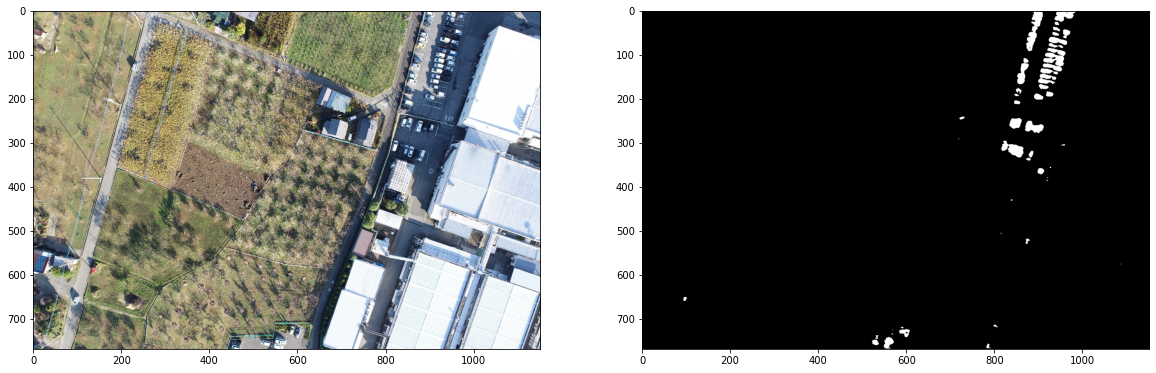

In [ ]:
import random
index = random.randint(0, len(test_set))
img, mask, filename = test_set[index]
pred_mask, score = predict_image_mask_miou(model, img, mask)
pred_mask = pred_mask.cpu().numpy().copy()
pred_mask = pred_mask.reshape(1,pred_mask.shape[0],pred_mask.shape[1])
print(filename)


import matplotlib.pyplot as plt
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(visualize(pred_mask))

## 任意の画像を一枚推論する

In [ ]:
def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [ ]:
filepath = IMAGE_PATH + 'DJI_0075.jpg'
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

aug = t_test(image=img, mask=mask)
img = Image.fromarray(aug['image'])

pred_mask = predict_image(model, img)
pred_mask = pred_mask.cpu().numpy().copy()
pred_mask = pred_mask.reshape(1,pred_mask.shape[0],pred_mask.shape[1])

print(filename)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(visualize(pred_mask))